In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
import xgboost as xgb
from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss
import librosa
import librosa.display
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Read in all feature files

initial_files = pd.read_csv('soundfile_names.csv')
initial_files['filename'] = "Data/genres_original/" + initial_files['label'] + "/" + initial_files['filename']
df = pd.DataFrame()
for i in initial_files['label'].unique():
    df = pd.concat([df, pd.read_csv(i + "_3secfeatures.csv")])

df = pd.merge(df, initial_files, on = 'filename')
df = df.reset_index(drop = True)

In [4]:
df

filename  segment    length  \
0     Data/genres_original/blues/blues.00000.wav        0  3.001315   
1     Data/genres_original/blues/blues.00000.wav        1  3.001315   
2     Data/genres_original/blues/blues.00000.wav        2  3.001315   
3     Data/genres_original/blues/blues.00000.wav        3  3.001315   
4     Data/genres_original/blues/blues.00000.wav        4  3.001315   
...                                          ...      ...       ...   
9985    Data/genres_original/rock/rock.00099.wav        5  3.001315   
9986    Data/genres_original/rock/rock.00099.wav        6  3.001315   
9987    Data/genres_original/rock/rock.00099.wav        7  3.001315   
9988    Data/genres_original/rock/rock.00099.wav        8  3.001315   
9989    Data/genres_original/rock/rock.00099.wav        9  3.001315   

      chroma_stft_mean  chroma_stft_std  chroma_stft_skew  \
0             0.335489         0.301540          1.020681   
1             0.343388         0.294134          1.063305   
2             0.347768         0.304301          0.901502   
3             0.361880         0.293975          0.932154   
4             0.333237         0.295735          1.137966   
...                ...              ...               ...   
9985          0.350875         0.285528          1.104394   
9986          0.372202         0.287078          0.947353   
9987          0.346419         0.296543          0.971608   
9988          0.385345         0.288441          0.827770   
9989          0.372464         0.296340          0.904212   

      chroma_stft_kurtosis  chroma_stft_median  chroma_stft_min  \
0                -0.117478            0.233150         0.006450   
1                -0.005006            0.242065         0.008723   
2                -0.354802            0.249102         0.001904   
3                -0.206249            0.277121         0.003071   
4                 0.120821            0.223887         0.014125   
...                    ...                 ...              ...   
9985              0.155631            0.259542         0.014124   
9986             -0.194736            0.283751         0.009554   
9987             -0.123995            0.260481         0.005840   
9988             -0.362811            0.310581         0.010072   
9989             -0.381605            0.266071         0.015886   

      chroma_cqt_mean  ...  mfcc_19_median  mfcc_19_min  mfcc_20_mean  \
0            0.540237  ...       -5.339299   -17.226530     -0.268043   
1            0.534423  ...       -3.035424   -27.615917      5.790949   
2            0.492449  ...       -2.821123   -14.269703      2.599745   
3            0.546121  ...       -3.458435   -20.385891      3.676203   
4            0.523493  ...       -3.374337   -14.924772      0.626625   
...               ...  ...             ...          ...           ...   
9985         0.275669  ...       -6.616860   -22.512262      1.590725   
9986         0.264091  ...      -11.639359   -32.296060      0.470529   
9987         0.279372  ...        1.916148   -16.393026     -0.258643   
9988         0.245671  ...        1.579786   -10.110823      0.668112   
9989         0.311601  ...       -7.663737   -21.030920     -3.407213   

      mfcc_20_std  mfcc_20_skew  mfcc_20_kurtosis  mfcc_20_median  \
0        6.606342      0.461468         -0.398294       -0.741886   
1        7.757394      0.311586         -0.664105        4.828741   
2        5.728702     -0.075088          0.232092        2.096988   
3        5.641251     -0.326931         -0.449859        4.313828   
4        5.455158      0.047006         -0.315896        0.740305   
...           ...           ...               ...             ...   
9985     6.191266      0.490316         -0.025570        1.512384   
9986     4.267436      0.077416         -0.204009        0.562108   
9987     6.516179      0.014085          0.052162       -0.519264   
9988     3.581738     -0.045326         -0.510658        1.187700   
9989     5.61

In [5]:
unique_filenames = df['filename'].unique()

train_files, test_files = train_test_split(unique_filenames, test_size=0.2, random_state=42)

train_df = df[df['filename'].isin(train_files)]
test_df = df[df['filename'].isin(test_files)]

In [6]:
X_cols = df.drop(columns = ['filename', 'segment', 'label', 'length']).columns
y_cols = 'label'

In [ ]:
#le = LabelEncoder()
#train_df['label'] = le.fit_transform(train_df['label'])
#test_df['label'] = le.transform(test_df['label'])

/var/folders/q3/hm2wt3010319t7l0hz8w8s4h0000gn/T/ipykernel_42393/3762488494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = le.fit_transform(train_df['label'])
/var/folders/q3/hm2wt3010319t7l0hz8w8s4h0000gn/T/ipykernel_42393/3762488494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['label'] = le.transform(test_df['label'])


In [7]:
scaler = StandardScaler()
train_df[X_cols] = scaler.fit_transform(train_df[X_cols])
test_df[X_cols] = scaler.transform(test_df[X_cols])

/var/folders/q3/hm2wt3010319t7l0hz8w8s4h0000gn/T/ipykernel_47819/660584782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[X_cols] = scaler.fit_transform(train_df[X_cols])
/var/folders/q3/hm2wt3010319t7l0hz8w8s4h0000gn/T/ipykernel_47819/660584782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[X_cols] = scaler.transform(test_df[X_cols])


In [7]:
print(train_df[X_cols].dtypes)
print(train_df[y_cols].dtypes)

chroma_stft_mean        float64
chroma_stft_std         float64
chroma_stft_skew        float64
chroma_stft_kurtosis    float64
chroma_stft_median      float64
                         ...   
mfcc_20_skew            float64
mfcc_20_kurtosis        float64
mfcc_20_median          float64
mfcc_20_min             float64
tempo                   float64
Length: 187, dtype: object
object


# EDA

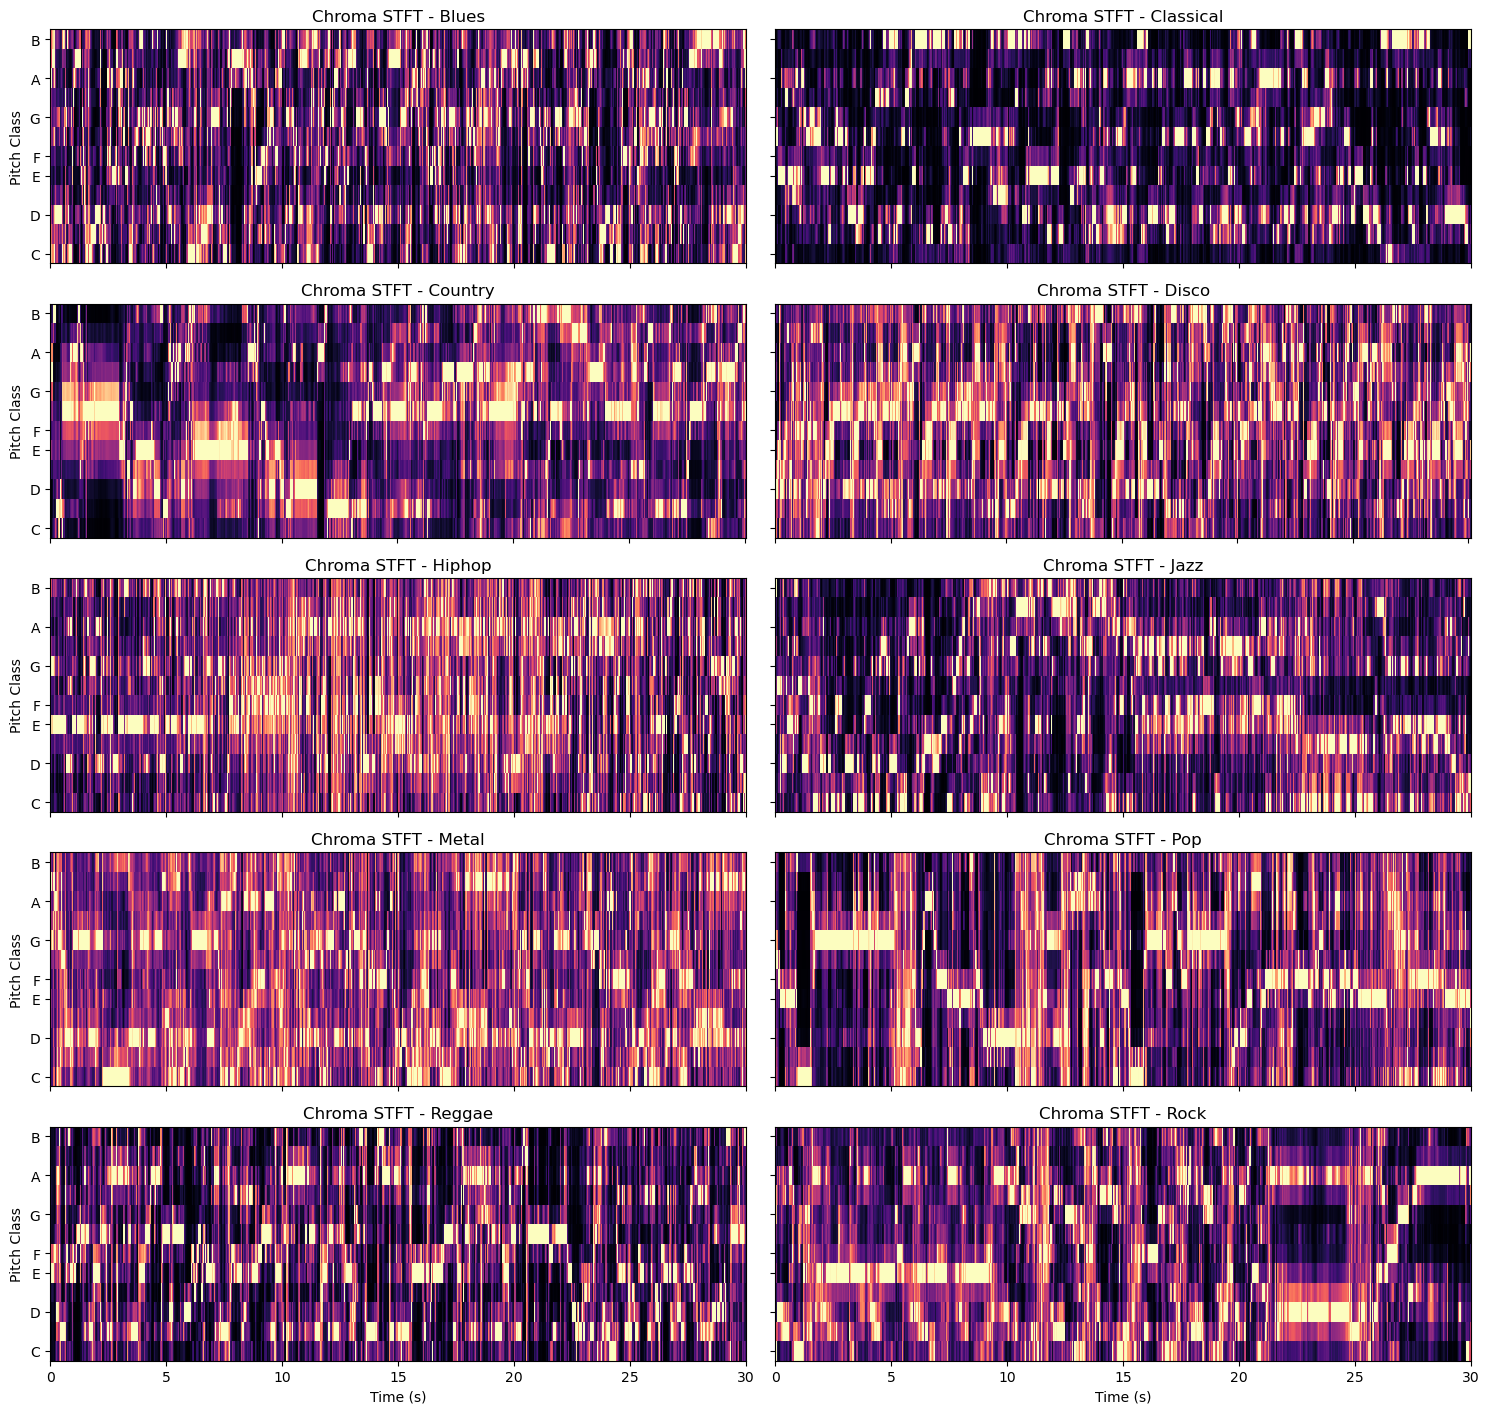

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define the genres and file paths
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']
file_paths = [f'Data/genres_original/{genre}/{genre}.00000.wav' for genre in genres]

# Create a 5x2 subplot
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Loop through each genre and plot its chroma STFT
for i, (genre, file_path) in enumerate(zip(genres, file_paths)):
    y, sr = librosa.load(file_path)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    
    ax = axes[i // 2, i % 2]
    img = librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', sr=sr, ax=ax)
    ax.set_title(f'Chroma STFT - {genre.capitalize()}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pitch Class')
    ax.label_outer()  # Only show labels on outer plots

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the colorbar
plt.show()


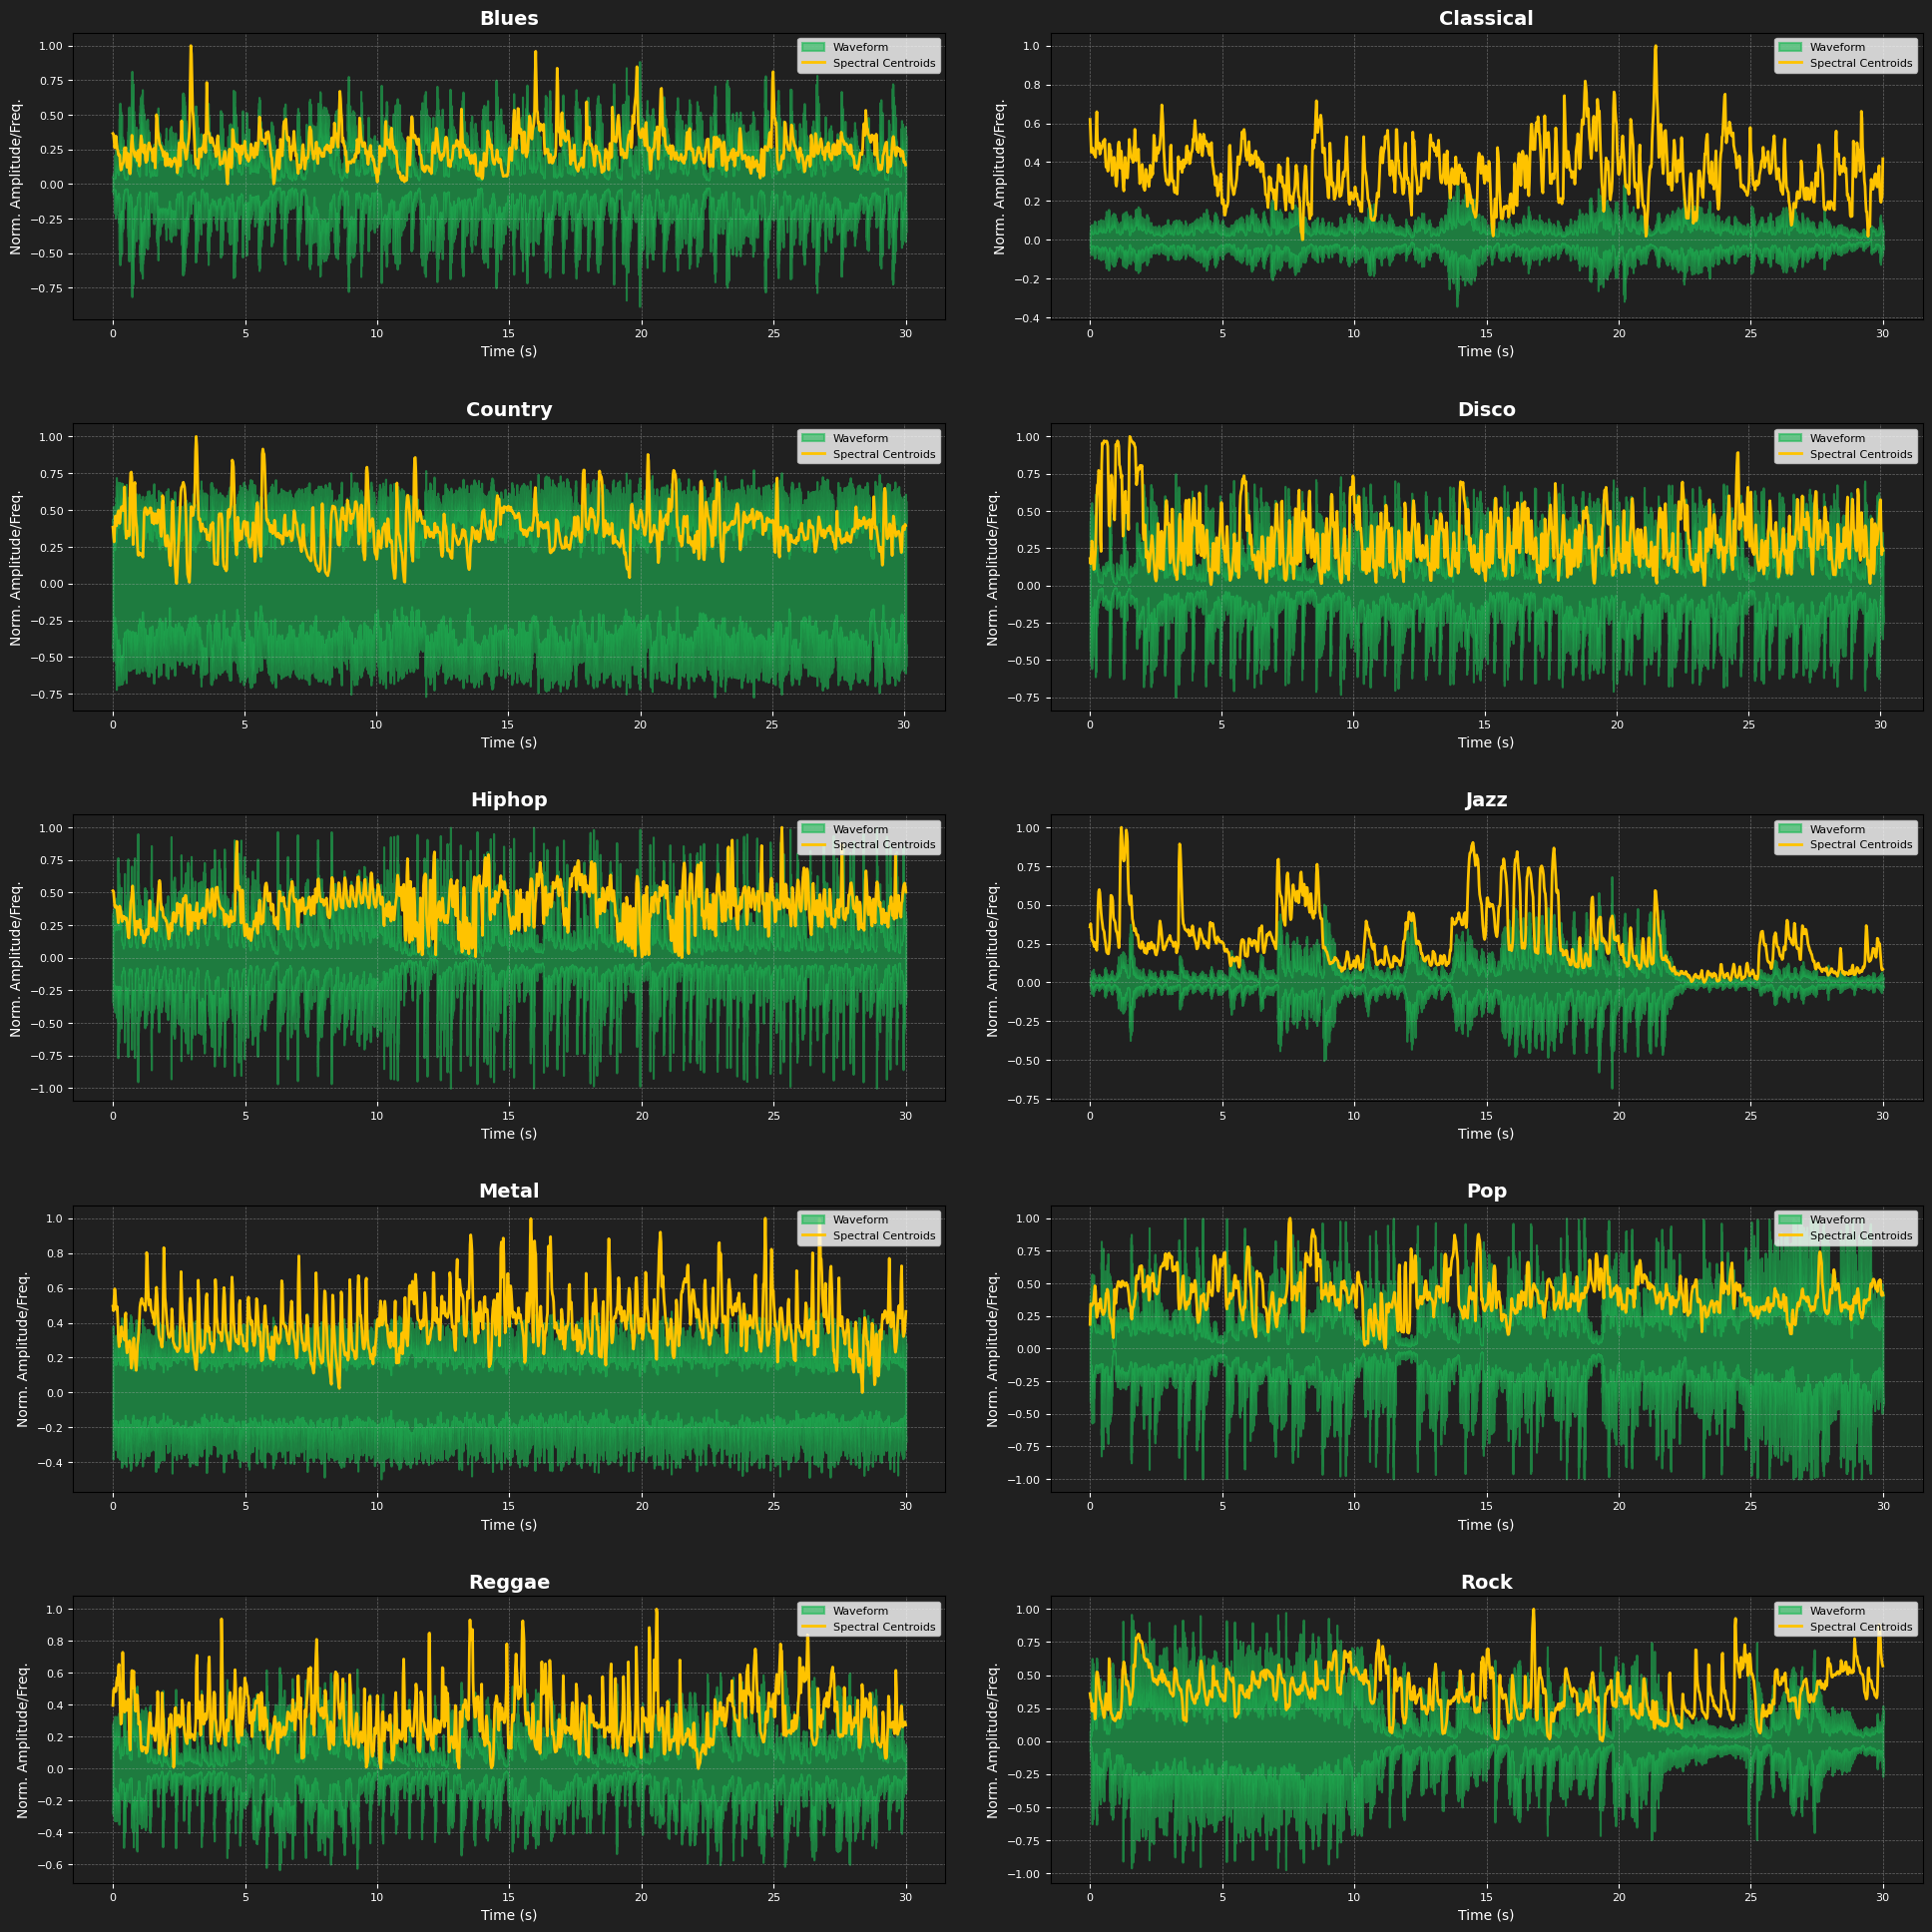

In [180]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
fig.patch.set_facecolor('#202020')  # Set background color for the figure

# Loop through each genre and plot in subplots
for i, (genre, file_path) in enumerate(zip(genres, file_paths)):
    # Load the audio file
    y, sr = librosa.load(file_path)
    
    # Calculate the spectral centroids
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    
    # Compute the time variable for visualization
    frames = range(len(spectral_centroids[0]))
    t = librosa.frames_to_time(frames, sr=sr)
    
    # Function to normalize the spectral centroid
    def normalize(x, axis=0):
        return minmax_scale(x, axis=axis)
    
    # Get subplot axis
    ax = axes[i // 2, i % 2]
    ax.set_facecolor('#202020')  # Set background color for individual subplot
    
    # Plot the waveform
    librosa.display.waveshow(y, sr=sr, alpha=0.6, color='#1DB954', linewidth=1.5, ax=ax, label='Waveform')
    
    # Plot the spectral centroids
    ax.plot(t, normalize(spectral_centroids[0]), color='#FFC300', linewidth=2, label='Spectral Centroids')
    
    # Enhancing the plot
    ax.set_title(f'{genre.capitalize()}', fontsize=14, fontweight='bold', color='white')
    ax.set_xlabel('Time (s)', fontsize=10, color='white')
    ax.set_ylabel('Norm. Amplitude/Freq.', fontsize=10, color='white')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.tick_params(axis='x', colors='white', labelsize=8)
    ax.tick_params(axis='y', colors='white', labelsize=8)

# Adjust layout
plt.tight_layout(pad=3)
plt.show()

/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be 

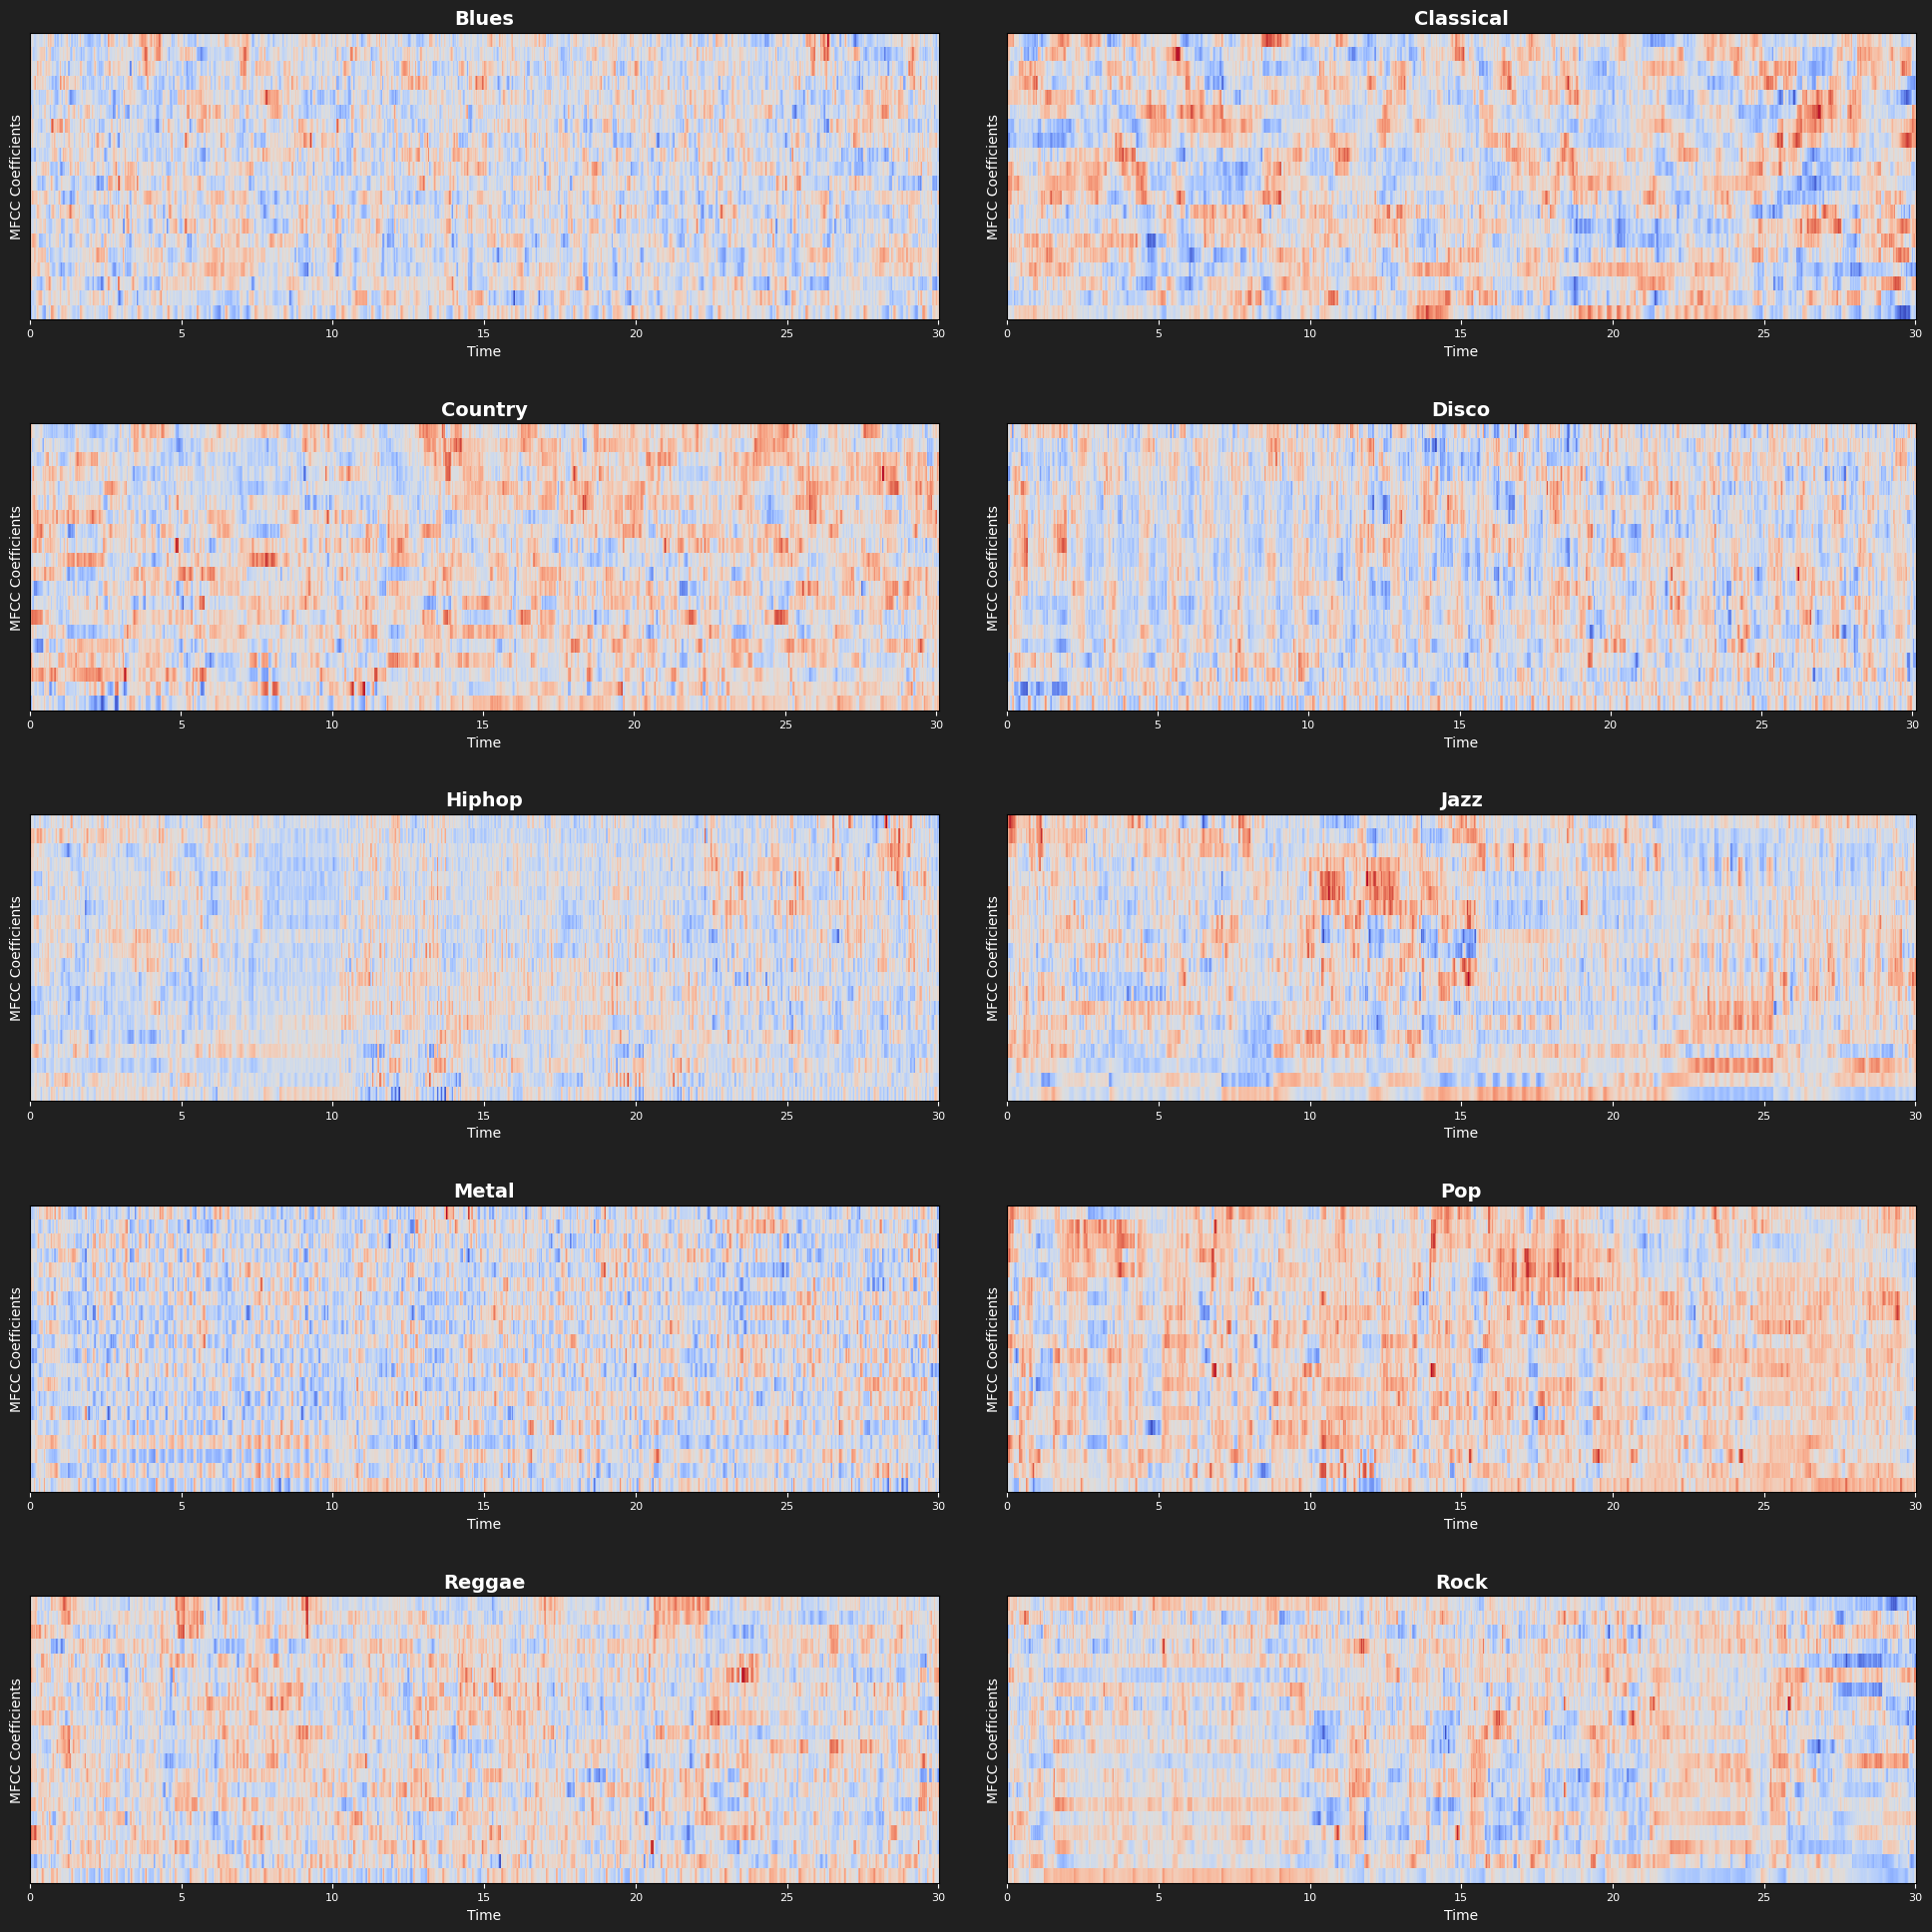

In [199]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

# Define genres and file paths
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']
file_paths = [f'Data/genres_original/{genre}/{genre}.00000.wav' for genre in genres]

# Create a 5x2 subplot
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
fig.patch.set_facecolor('#202020')  # Set background color for the figure

# Loop through each genre and plot in subplots
for i, (genre, file_path) in enumerate(zip(genres, file_paths)):
    # Load the audio file
    y, sr = librosa.load(file_path)
    
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    # Apply Feature Scaling
    mfccs = scale(mfccs, axis=1)
    
    # Get subplot axis
    ax = axes[i // 2, i % 2]
    ax.set_facecolor('#202020')  # Set background color for individual subplot
    
    # Plot MFCCs
    img = librosa.display.specshow(mfccs, x_axis='time', cmap='coolwarm', ax=ax)
    ax.set_title(f'{genre.capitalize()}', fontsize=14, fontweight='bold', color='white')
    ax.set_xlabel('Time', fontsize=10, color='white')
    ax.set_ylabel('MFCC Coefficients', fontsize=10, color='white')
    ax.tick_params(axis='x', colors='white', labelsize=8)
    ax.tick_params(axis='y', colors='white', labelsize=8)


# Adjust layout
plt.tight_layout(pad=3)
plt.show()


In [200]:
len(X_cols)

187

### Decision Tree

In [90]:
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier
clf.fit(train_df[X_cols], train_df[y_cols])

DecisionTreeClassifier(random_state=42)

In [91]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(train_df[y_cols], clf.predict(train_df[X_cols])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       880
           2       1.00      1.00      1.00       760
           3       1.00      1.00      1.00       780
           4       1.00      1.00      1.00       850
           5       1.00      1.00      1.00       720
           6       1.00      1.00      1.00       820
           7       1.00      1.00      1.00       810
           8       1.00      1.00      1.00       780
           9       1.00      1.00      1.00       800

    accuracy                           1.00      7990
   macro avg       1.00      1.00      1.00      7990
weighted avg       1.00      1.00      1.00      7990



In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(test_df[y_cols], clf.predict(test_df[X_cols])))

              precision    recall  f1-score   support

           0       0.49      0.44      0.46       210
           1       0.71      0.87      0.78       120
           2       0.41      0.41      0.41       240
           3       0.50      0.51      0.50       220
           4       0.40      0.60      0.48       150
           5       0.74      0.64      0.69       270
           6       0.63      0.68      0.65       180
           7       0.59      0.51      0.55       190
           8       0.55      0.45      0.49       220
           9       0.23      0.23      0.23       200

    accuracy                           0.52      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.52      0.52      0.52      2000



In [93]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score


clf_accuracy = accuracy_score(test_df['label'], clf.predict(test_df[X_cols]))
clf_precision = precision_score(test_df['label'], clf.predict(test_df[X_cols]), average='macro')
clf_recall = recall_score(test_df['label'], clf.predict(test_df[X_cols]), average = 'macro')
clf_roc_auc = roc_auc_score(test_df['label'], clf.predict_proba(test_df[X_cols]), multi_class='ovr')

In [97]:
clf_roc_auc

0.7401835462518336

### Random Forest

In [83]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(train_df[X_cols], train_df[y_cols])

RandomForestClassifier(random_state=42)

In [94]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(train_df[y_cols], rf.predict(train_df[X_cols])))

              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       790
   classical       1.00      1.00      1.00       880
     country       1.00      1.00      1.00       760
       disco       1.00      1.00      1.00       780
      hiphop       1.00      1.00      1.00       850
        jazz       1.00      1.00      1.00       720
       metal       1.00      1.00      1.00       820
         pop       1.00      1.00      1.00       810
      reggae       1.00      1.00      1.00       780
        rock       1.00      1.00      1.00       800

    accuracy                           1.00      7990
   macro avg       1.00      1.00      1.00      7990
weighted avg       1.00      1.00      1.00      7990



In [95]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(test_df[y_cols], rf.predict(test_df[X_cols])))

              precision    recall  f1-score   support

       blues       0.71      0.69      0.70       210
   classical       0.75      0.99      0.86       120
     country       0.67      0.70      0.69       240
       disco       0.74      0.69      0.71       220
      hiphop       0.60      0.75      0.67       150
        jazz       0.87      0.84      0.85       270
       metal       0.73      0.87      0.79       180
         pop       0.85      0.75      0.80       190
      reggae       0.72      0.70      0.71       220
        rock       0.40      0.28      0.33       200

    accuracy                           0.72      2000
   macro avg       0.70      0.73      0.71      2000
weighted avg       0.71      0.72      0.71      2000



In [84]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score


rf_accuracy = accuracy_score(test_df['label'], rf.predict(test_df[X_cols]))
rf_precision = precision_score(test_df['label'], rf.predict(test_df[X_cols]), average='macro')
rf_recall = recall_score(test_df['label'], rf.predict(test_df[X_cols]), average = 'macro')
rf_roc_auc = roc_auc_score(test_df['label'], rf.predict_proba(test_df[X_cols]), multi_class='ovr')

In [88]:
rf_roc_auc

0.9486550398095378

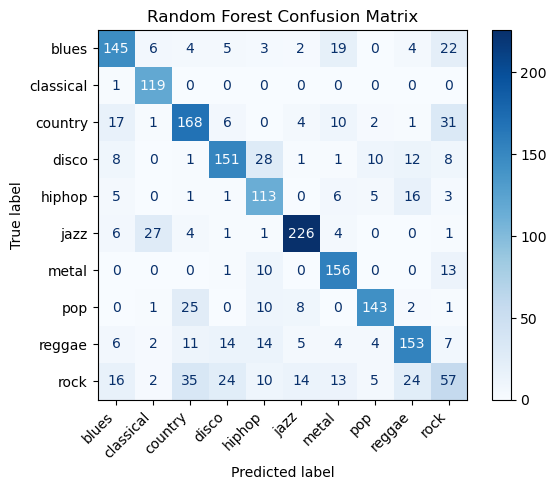

In [96]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_df['label'], rf.predict(test_df[X_cols]))
genre_labels = test_df['label'].unique()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.title("Random Forest Confusion Matrix")
plt.show()

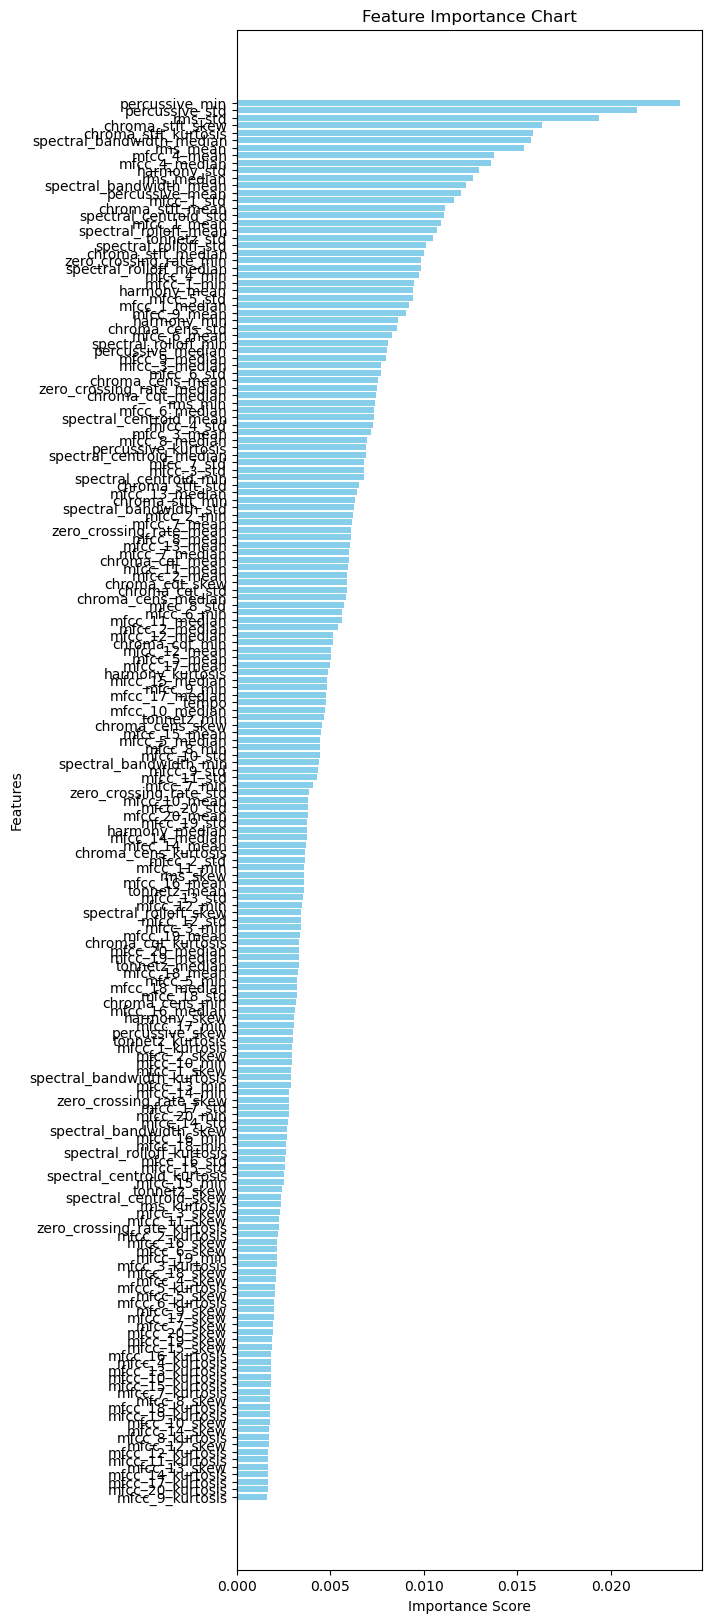

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming rf is your trained Random Forest model
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_cols,  # List of feature names
    'Importance': feature_importances
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(6, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Chart')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


### Random Forest Feature Reduction

##### Remove Median values

In [49]:
X_cols_no_median = [col for col in X_cols if 'median' not in col]

# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(train_df[X_cols_no_median], train_df[y_cols])

RandomForestClassifier(random_state=42)

In [47]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(train_df[y_cols], rf.predict(train_df[X_cols_no_median])))

              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       790
   classical       1.00      1.00      1.00       880
     country       1.00      1.00      1.00       760
       disco       1.00      1.00      1.00       780
      hiphop       1.00      1.00      1.00       850
        jazz       1.00      1.00      1.00       720
       metal       1.00      1.00      1.00       820
         pop       1.00      1.00      1.00       810
      reggae       1.00      1.00      1.00       780
        rock       1.00      1.00      1.00       800

    accuracy                           1.00      7990
   macro avg       1.00      1.00      1.00      7990
weighted avg       1.00      1.00      1.00      7990



In [48]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(test_df[y_cols], rf.predict(test_df[X_cols_no_median])))

              precision    recall  f1-score   support

       blues       0.75      0.69      0.72       210
   classical       0.72      0.99      0.83       120
     country       0.68      0.74      0.71       240
       disco       0.70      0.72      0.71       220
      hiphop       0.65      0.75      0.70       150
        jazz       0.88      0.82      0.85       270
       metal       0.73      0.85      0.79       180
         pop       0.89      0.77      0.83       190
      reggae       0.71      0.70      0.71       220
        rock       0.45      0.33      0.38       200

    accuracy                           0.73      2000
   macro avg       0.72      0.74      0.72      2000
weighted avg       0.72      0.73      0.72      2000



##### Remove Chroma Cqt and Chroma Cens

In [57]:
X_cols_remove_chroma = [col for col in X_cols_no_median if 'chroma_cqt' not in col and 'chroma_cens' not in col]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_df[X_cols_remove_chroma], train_df[y_cols])

RandomForestClassifier(random_state=42)

In [59]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(train_df[y_cols], rf.predict(train_df[X_cols_remove_chroma])))

              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       790
   classical       1.00      1.00      1.00       880
     country       1.00      1.00      1.00       760
       disco       1.00      1.00      1.00       780
      hiphop       1.00      1.00      1.00       850
        jazz       1.00      1.00      1.00       720
       metal       1.00      1.00      1.00       820
         pop       1.00      1.00      1.00       810
      reggae       1.00      1.00      1.00       780
        rock       1.00      1.00      1.00       800

    accuracy                           1.00      7990
   macro avg       1.00      1.00      1.00      7990
weighted avg       1.00      1.00      1.00      7990



In [58]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(test_df[y_cols], rf.predict(test_df[X_cols_remove_chroma])))

              precision    recall  f1-score   support

       blues       0.73      0.73      0.73       210
   classical       0.70      0.99      0.82       120
     country       0.71      0.74      0.72       240
       disco       0.72      0.69      0.70       220
      hiphop       0.63      0.79      0.70       150
        jazz       0.87      0.81      0.84       270
       metal       0.72      0.91      0.80       180
         pop       0.88      0.77      0.82       190
      reggae       0.75      0.70      0.73       220
        rock       0.51      0.32      0.39       200

    accuracy                           0.73      2000
   macro avg       0.72      0.74      0.73      2000
weighted avg       0.73      0.73      0.73      2000



In [81]:
X_cols_limit_mfcc = [col for col in X_cols_remove_chroma if ('kurtosis' not in col and 'skew' not in col) or 'mfcc' not in col]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_df[X_cols_limit_mfcc], train_df[y_cols])

RandomForestClassifier(random_state=42)

In [82]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(train_df[y_cols], rf.predict(train_df[X_cols_limit_mfcc])))

              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       790
   classical       1.00      1.00      1.00       880
     country       1.00      1.00      1.00       760
       disco       1.00      1.00      1.00       780
      hiphop       1.00      1.00      1.00       850
        jazz       1.00      1.00      1.00       720
       metal       1.00      1.00      1.00       820
         pop       1.00      1.00      1.00       810
      reggae       1.00      1.00      1.00       780
        rock       1.00      1.00      1.00       800

    accuracy                           1.00      7990
   macro avg       1.00      1.00      1.00      7990
weighted avg       1.00      1.00      1.00      7990



In [83]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(test_df[y_cols], rf.predict(test_df[X_cols_limit_mfcc])))

              precision    recall  f1-score   support

       blues       0.73      0.79      0.76       210
   classical       0.73      0.99      0.84       120
     country       0.71      0.72      0.71       240
       disco       0.71      0.64      0.67       220
      hiphop       0.60      0.74      0.66       150
        jazz       0.87      0.82      0.85       270
       metal       0.74      0.88      0.80       180
         pop       0.87      0.80      0.83       190
      reggae       0.73      0.68      0.70       220
        rock       0.49      0.34      0.40       200

    accuracy                           0.73      2000
   macro avg       0.72      0.74      0.72      2000
weighted avg       0.73      0.73      0.72      2000



In [82]:
X_cols_just_mean_and_std = [col for col in X_cols_limit_mfcc if 'mean' in col or 'std' in col]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_df[X_cols_just_mean_and_std], train_df[y_cols])

NameError: name 'X_cols_limit_mfcc' is not defined

In [90]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(train_df[y_cols], rf.predict(train_df[X_cols_just_mean_and_std])))

              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       790
   classical       1.00      1.00      1.00       880
     country       1.00      1.00      1.00       760
       disco       1.00      1.00      1.00       780
      hiphop       1.00      1.00      1.00       850
        jazz       1.00      1.00      1.00       720
       metal       1.00      1.00      1.00       820
         pop       1.00      1.00      1.00       810
      reggae       1.00      1.00      1.00       780
        rock       1.00      1.00      1.00       800

    accuracy                           1.00      7990
   macro avg       1.00      1.00      1.00      7990
weighted avg       1.00      1.00      1.00      7990



In [88]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(test_df[y_cols], rf.predict(test_df[X_cols_just_mean_and_std])))

              precision    recall  f1-score   support

       blues       0.75      0.74      0.75       210
   classical       0.74      0.99      0.85       120
     country       0.68      0.75      0.71       240
       disco       0.69      0.63      0.66       220
      hiphop       0.65      0.73      0.69       150
        jazz       0.87      0.84      0.85       270
       metal       0.74      0.87      0.80       180
         pop       0.86      0.77      0.81       190
      reggae       0.73      0.66      0.69       220
        rock       0.46      0.35      0.40       200

    accuracy                           0.72      2000
   macro avg       0.72      0.73      0.72      2000
weighted avg       0.72      0.72      0.72      2000



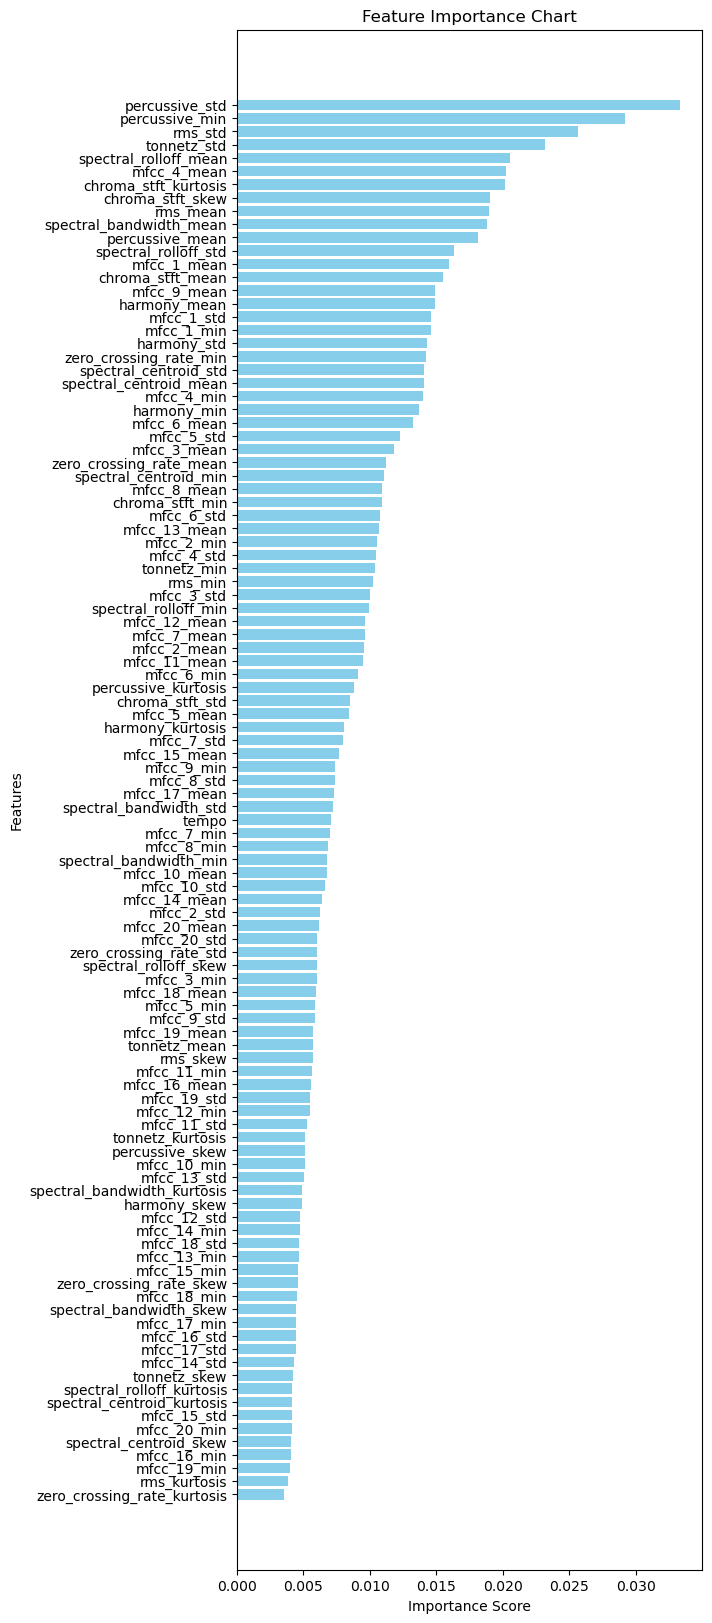

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming rf is your trained Random Forest model
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_cols_limit_mfcc,  # List of feature names
    'Importance': feature_importances
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(6, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Chart')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


### KNN

In [54]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_df[X_cols], train_df[y_cols])

KNeighborsClassifier()

In [55]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(train_df[y_cols], knn.predict(train_df[X_cols])))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       790
           1       0.92      0.99      0.96       880
           2       0.95      0.95      0.95       760
           3       0.93      0.98      0.95       780
           4       0.97      0.97      0.97       850
           5       0.97      0.89      0.93       720
           6       0.97      0.97      0.97       820
           7       0.98      0.94      0.96       810
           8       0.97      0.98      0.98       780
           9       0.97      0.94      0.95       800

    accuracy                           0.96      7990
   macro avg       0.96      0.96      0.96      7990
weighted avg       0.96      0.96      0.96      7990



In [56]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(test_df[y_cols], knn.predict(test_df[X_cols])))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       210
           1       0.54      0.97      0.70       120
           2       0.65      0.75      0.69       240
           3       0.57      0.64      0.60       220
           4       0.55      0.68      0.61       150
           5       0.86      0.64      0.73       270
           6       0.79      0.78      0.78       180
           7       0.84      0.67      0.74       190
           8       0.71      0.60      0.65       220
           9       0.51      0.35      0.42       200

    accuracy                           0.67      2000
   macro avg       0.68      0.69      0.67      2000
weighted avg       0.69      0.67      0.67      2000



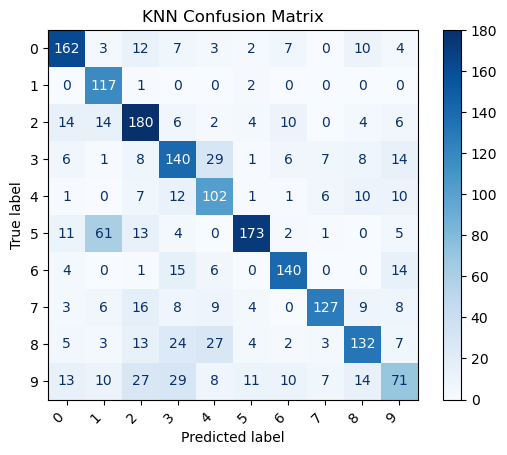

In [57]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_df['label'], knn.predict(test_df[X_cols]))
genre_labels = test_df['label'].unique()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.title("KNN Confusion Matrix")
plt.show()

In [79]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score


knn_accuracy = accuracy_score(test_df['label'], knn.predict(test_df[X_cols]))
knn_precision = precision_score(test_df['label'], knn.predict(test_df[X_cols]), average='macro')
knn_recall = recall_score(test_df['label'], knn.predict(test_df[X_cols]), average = 'macro')
knn_roc_auc = roc_auc_score(test_df['label'], knn.predict_proba(test_df[X_cols]), multi_class='ovr')

In [80]:
knn_accuracy

0.672

### XGBoost

In [11]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
test_df['label'] = le.transform(test_df['label'])

/var/folders/q3/hm2wt3010319t7l0hz8w8s4h0000gn/T/ipykernel_47819/4281816221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = le.fit_transform(train_df['label'])
/var/folders/q3/hm2wt3010319t7l0hz8w8s4h0000gn/T/ipykernel_47819/4281816221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['label'] = le.transform(test_df['label'])


In [102]:
# Define the train_and_evaluate function
def train_and_evaluate(params):
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_df[X_cols], train_df[y_cols], test_size=0.2, random_state=42)

    # Create a model using the hyperparameters
    model = xgb.XGBClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
        eval_metric='logloss'  # Set evaluation metric
    )

    # Train the model
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)

    # Calculate the log loss on the validation set
    logloss = log_loss(y_val, y_pred_proba)

    # Return the log loss as the loss (lower log loss is better)
    return logloss

# Define the search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1), 
    'n_estimators': hp.randint('n_estimators', 200, 1200),
    'max_depth': hp.randint('max_depth', 3, 25),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

# Define the objective function
def objective(params):
    # Train your model with the given params and evaluate its performance
    score = train_and_evaluate(params)  # Call the defined training and evaluation function
    return {'loss': score, 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Run the optimization using Adaptive TPE
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest,  # TPE is the standard; Adaptive TPE is a variant that automatically adapts
            max_evals=20, 
            trials=trials)

# Output the best hyperparameters found
print("Best hyperparameters:", best)


100%|██████████| 20/20 [41:02<00:00, 123.11s/trial, best loss: 0.2724460602644005]
Best hyperparameters: {'colsample_bytree': 0.5757914839493082, 'learning_rate': 0.047607611358493625, 'max_depth': 15, 'n_estimators': 1187}


In [150]:
# Define the train_and_evaluate function
def train_and_evaluate(params):
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_df[X_cols_just_mean_and_std], train_df[y_cols], test_size=0.2, random_state=42)

    # Create a model using the hyperparameters
    model = xgb.XGBClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
        eval_metric='logloss'  # Set evaluation metric
    )

    # Train the model
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)

    # Calculate the log loss on the validation set
    logloss = log_loss(y_val, y_pred_proba)

    # Return the log loss as the loss (lower log loss is better)
    return logloss

# Define the search space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1), 
    'n_estimators': hp.randint('n_estimators', 200, 1200),
    'max_depth': hp.randint('max_depth', 3, 25),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
}

# Define the objective function
def objective(params):
    # Train your model with the given params and evaluate its performance
    score = train_and_evaluate(params)  # Call the defined training and evaluation function
    return {'loss': score, 'status': STATUS_OK}

# Create a Trials object to track the optimization process
trials = Trials()

# Run the optimization using Adaptive TPE
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest,  # TPE is the standard; Adaptive TPE is a variant that automatically adapts
            max_evals=100, 
            trials=trials)

# Output the best hyperparameters found
print("Best hyperparameters:", best)


100%|██████████| 100/100 [1:48:44<00:00, 65.24s/trial, best loss: 0.2501087417898707] 
Best hyperparameters: {'colsample_bytree': 0.4680400583077041, 'learning_rate': 0.06395079057442944, 'max_depth': 6, 'n_estimators': 952}


In [32]:
xgb_model = xgb.XGBClassifier(
        n_estimators=1187,
        max_depth=15,
        learning_rate=0.047607611358493625,
        colsample_bytree=0.5757914839493082,
        random_state=42,
        eval_metric='logloss'  # Set evaluation metric
    )

In [33]:
xgb_model.fit(train_df[X_cols], y = train_df[y_cols])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5757914839493082, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.047607611358493625, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1187, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

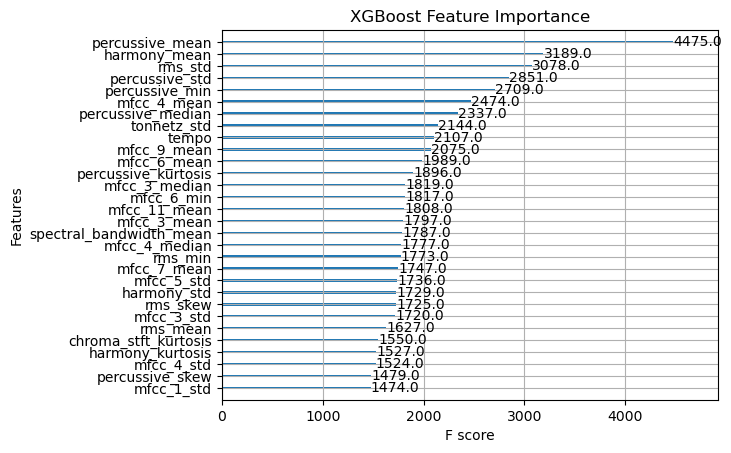

In [52]:
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=30, title='XGBoost Feature Importance')
plt.show()

In [20]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(le.inverse_transform(train_df[y_cols]), le.inverse_transform(xgb_model.predict(train_df[X_cols]))))

              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       790
   classical       1.00      1.00      1.00       880
     country       1.00      1.00      1.00       760
       disco       1.00      1.00      1.00       780
      hiphop       1.00      1.00      1.00       850
        jazz       1.00      1.00      1.00       720
       metal       1.00      1.00      1.00       820
         pop       1.00      1.00      1.00       810
      reggae       1.00      1.00      1.00       780
        rock       1.00      1.00      1.00       800

    accuracy                           1.00      7990
   macro avg       1.00      1.00      1.00      7990
weighted avg       1.00      1.00      1.00      7990



In [21]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(le.inverse_transform(test_df[y_cols]), le.inverse_transform(xgb_model.predict(test_df[X_cols]))))

              precision    recall  f1-score   support

       blues       0.77      0.83      0.80       210
   classical       0.82      0.99      0.90       120
     country       0.70      0.75      0.72       240
       disco       0.78      0.68      0.73       220
      hiphop       0.70      0.75      0.72       150
        jazz       0.93      0.89      0.91       270
       metal       0.74      0.90      0.81       180
         pop       0.83      0.82      0.83       190
      reggae       0.80      0.69      0.74       220
        rock       0.52      0.43      0.48       200

    accuracy                           0.77      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.76      0.77      0.76      2000



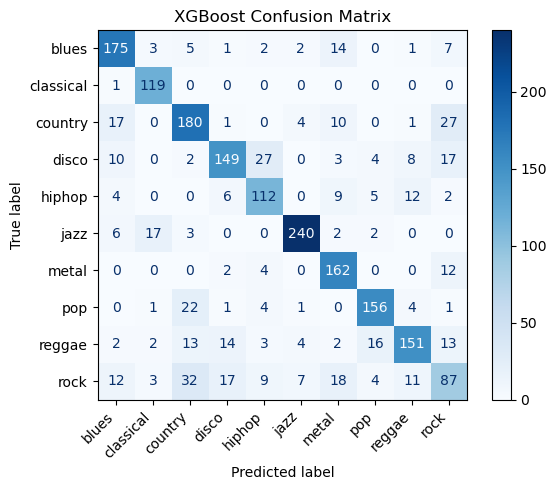

In [22]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_df['label'], xgb_model.predict(test_df[X_cols]))
genre_labels = le.inverse_transform(test_df['label'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.title("XGBoost Confusion Matrix")
plt.show()

### CNN

In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

X_train, X_val, y_train, y_val = train_test_split(train_df[X_cols], train_df[y_cols], test_size=0.125, random_state=42)

X_train = X_train.values
y_train = y_train.values

X_val = X_val.values
y_val = y_val.values

X_test = test_df[X_cols].values
y_test = test_df[y_cols].values

X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)

# Step 6: Build the CNN Model
model = models.Sequential([
    # First Convolutional Layer
    layers.Conv2D(32, (1, 3), activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], X_train_reshaped.shape[3])),
    layers.MaxPooling2D((1, 2)),

    # Second Convolutional Layer
    layers.Conv2D(64, (1, 3), activation='relu'),
    layers.MaxPooling2D((1, 2)),

    # Third Convolutional Layer
    layers.Conv2D(128, (1, 3), activation='relu'),
    layers.MaxPooling2D((1, 2)),

    # Flatten the 3D outputs to 1D
    layers.Flatten(),
    
    # Fully Connected Layer
    layers.Dense(128, activation='relu'),
    
    # Output Layer for multi-class classification
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Step 7: Train the Model
history = model.fit(
    X_train_reshaped, train_df['label'],
    validation_data=(X_val_reshaped, y_val[y_cols]),
    epochs=10,  # You can adjust the number of epochs
    batch_size=32  # You can adjust the batch size
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 185, 32)        128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 92, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 90, 64)         6208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 45, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 43, 128)        24704     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 21, 128)       0

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# New File Evaluation

In [23]:
new_videos = pd.read_csv('custom_song_features.csv')
new_videos = new_videos.drop(columns = ['Unnamed: 0'])
new_videos['label'] = le.transform(new_videos['genre'])
new_videos

filename  segment  length  \
0      /Users/carson/aml-music/Data/music_extracted/p...        0       3   
1      /Users/carson/aml-music/Data/music_extracted/p...        1       3   
2      /Users/carson/aml-music/Data/music_extracted/p...        2       3   
3      /Users/carson/aml-music/Data/music_extracted/p...        3       3   
4      /Users/carson/aml-music/Data/music_extracted/p...        4       3   
...                                                  ...      ...     ...   
16969  /Users/carson/aml-music/Data/music_extracted/j...       96       3   
16970  /Users/carson/aml-music/Data/music_extracted/j...       97       3   
16971  /Users/carson/aml-music/Data/music_extracted/j...       98       3   
16972  /Users/carson/aml-music/Data/music_extracted/j...       99       3   
16973  /Users/carson/aml-music/Data/music_extracted/j...      100       3   

       chroma_stft_mean  chroma_stft_std  chroma_stft_skew  \
0              0.401813         0.327726          0.183252   
1              0.544555         0.251707          0.269058   
2              0.592002         0.264261         -0.231615   
3              0.658083         0.203790          0.032818   
4              0.650039         0.207595          0.011922   
...                 ...              ...               ...   
16969          0.526701         0.293894          0.089637   
16970          0.407806         0.314810          0.576743   
16971          0.460262         0.301435          0.350008   
16972          0.499169         0.293126          0.176468   
16973          0.401357         0.315222          0.558496   

       chroma_stft_kurtosis  chroma_stft_median  chroma_stft_min  \
0                 -1.106295            0.411137         0.000000   
1                 -0.851386            0.515716         0.027985   
2                 -0.769368            0.607812         0.004029   
3                 -0.840015            0.642871         0.161227   
4                 -0.806134            0.641715         0.101101   
...                     ...                 ...              ...   
16969             -1.202188            0.508630         0.018586   
16970             -0.922388            0.334936         0.001068   
16971             -1.031196            0.416258         0.004966   
16972             -1.109606            0.478375         0.013097   
16973             -0.916112            0.328792         0.001939   

       chroma_cqt_mean  ...  mfcc_19_min  mfcc_20_mean  mfcc_20_std  \
0             0.452390  ...   -16.621260      0.774741     3.078783   
1             0.600131  ...   -19.307530      2.139871     4.793799   
2             0.678765  ...   -12.941784      1.521937     4.821578   
3             0.679449  ...   -12.339119      1.721230     3.794367   
4             0.688687  ...   -14.667474      2.106563     4.672123   
...                ...  ...          ...           ...          ...   
16969         0.608127  ...   -14.402899      3.193713     8.200100   
16970         0.614882  ...   -12.726092      8.788071    10.787657   
16971         0.601705  ...   -21.175072      5.426207     7.388105   
16972         0.609310  ...   -25.803864      8.008111     9.928221   
16973         0.634689  ...   -23.637745      2.835574     9.407687   

       mfcc_20_skew  mfcc_20_kurtosis  mfcc_20_median  mfcc_20_min  \
0          0.017335          1.191523        0.000000   -10.270206   
1          0.435874         -0.046180        2.019626    -7.701082   
2          0.257725          0.104134        0.914120   -11.763607   
3          0.041300          0.739907        1.821746   -10.733788   
4          0.001524          0.324712        1.533571   -11.142745   
...             ...               ...             ...          ...   
16969     -0.539063         -0.212058        4.330453   -18.791008   
16970      0.021738         -0.075349        8.748662   -17.626427   
16971     -0.470745         -0.153447        6.352828   -16.710958   
16972   

In [24]:
new_videos['label'] = le.transform(new_videos['genre'])

In [25]:
scaler = StandardScaler()
new_videos[X_cols] = scaler.fit_transform(new_videos[X_cols])

In [117]:
new_videos['pred'] = xgb_model.predict(new_videos[X_cols])

In [118]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(le.inverse_transform(new_videos['label']), le.inverse_transform(new_videos['pred'])))

              precision    recall  f1-score   support

       blues       0.26      0.10      0.15      1991
   classical       0.62      0.71      0.66      1866
     country       0.36      0.23      0.28      1482
       disco       0.17      0.22      0.19      1453
      hiphop       0.29      0.45      0.35      1433
        jazz       0.52      0.45      0.48      2271
       metal       0.49      0.54      0.52      1702
         pop       0.21      0.10      0.14      1520
      reggae       0.29      0.46      0.35      1523
        rock       0.20      0.23      0.21      1733

    accuracy                           0.36     16974
   macro avg       0.34      0.35      0.33     16974
weighted avg       0.35      0.36      0.34     16974



In [129]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, f1_score


xgb_accuracy = accuracy_score(le.inverse_transform(new_videos['label']), le.inverse_transform(xgb_model.predict(new_videos[X_cols])))

xgb_precision = precision_score(le.inverse_transform(new_videos['label']), le.inverse_transform(xgb_model.predict(new_videos[X_cols])), average='macro')
xgb_recall = recall_score(le.inverse_transform(new_videos['label']), le.inverse_transform(xgb_model.predict(new_videos[X_cols])), average = 'macro')
xgb_f1 = f1_score(le.inverse_transform(new_videos['label']), le.inverse_transform(xgb_model.predict(new_videos[X_cols])), average = 'macro')

In [130]:
xgb_f1

0.3344708737489025

In [ ]:
xgb_

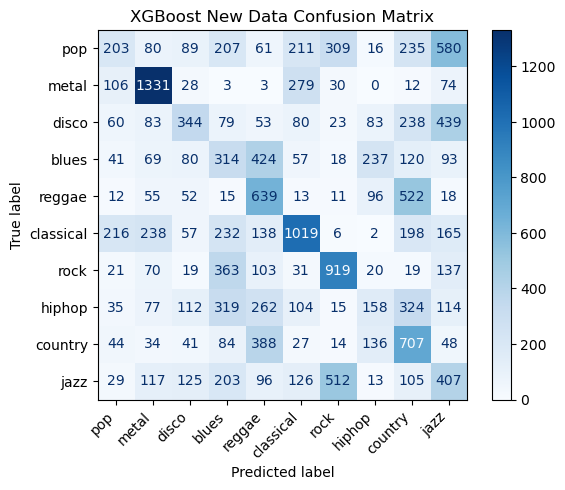

In [105]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(le.inverse_transform(new_videos['label']), le.inverse_transform(new_videos['pred']))
genre_labels = le.inverse_transform(new_videos['label'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.title("XGBoost New Data Confusion Matrix")
plt.show()

In [29]:
new_videos

filename  segment  length  \
0      /Users/carson/aml-music/Data/music_extracted/p...        0       3   
1      /Users/carson/aml-music/Data/music_extracted/p...        1       3   
2      /Users/carson/aml-music/Data/music_extracted/p...        2       3   
3      /Users/carson/aml-music/Data/music_extracted/p...        3       3   
4      /Users/carson/aml-music/Data/music_extracted/p...        4       3   
...                                                  ...      ...     ...   
16969  /Users/carson/aml-music/Data/music_extracted/j...       96       3   
16970  /Users/carson/aml-music/Data/music_extracted/j...       97       3   
16971  /Users/carson/aml-music/Data/music_extracted/j...       98       3   
16972  /Users/carson/aml-music/Data/music_extracted/j...       99       3   
16973  /Users/carson/aml-music/Data/music_extracted/j...      100       3   

       chroma_stft_mean  chroma_stft_std  chroma_stft_skew  \
0              0.167050         1.560130         -1.443679   
1              1.593605        -1.332159         -1.265042   
2              2.067780        -0.854527         -2.307372   
3              2.728192        -3.155282         -1.756862   
4              2.647794        -3.010527         -1.800363   
...                 ...              ...               ...   
16969          1.415165         0.272929         -1.638572   
16970          0.226948         1.068708         -0.624487   
16971          0.751184         0.559853         -1.096517   
16972          1.140022         0.243721         -1.457801   
16973          0.162495         1.084411         -0.662475   

       chroma_stft_kurtosis  chroma_stft_median  chroma_stft_min  \
0                 -0.823407            0.824792        -0.729193   
1                 -0.612128            1.629402         0.360501   
2                 -0.544148            2.337963        -0.572316   
3                 -0.602703            2.607701         5.548741   
4                 -0.574621            2.598810         3.207520   
...                     ...                 ...              ...   
16969             -0.902887            1.574886        -0.005497   
16970             -0.670978            0.238524        -0.687590   
16971             -0.761162            0.864192        -0.535817   
16972             -0.826152            1.342105        -0.219212   
16973             -0.665775            0.191249        -0.653697   

       chroma_cqt_mean  ...  mfcc_20_mean  mfcc_20_std  mfcc_20_skew  \
0             0.103003  ...      0.049897    -1.504186     -0.122847   
1             1.348077  ...      0.318986    -0.797223      0.780293   
2             2.010758  ...      0.197181    -0.785772      0.395876   
3             2.016526  ...      0.236465    -1.209208     -0.071134   
4             2.094371  ...      0.312421    -0.847380     -0.156965   
...                ...  ...           ...          ...           ...   
16969         1.415460  ...      0.526716     0.606920     -1.323462   
16970         1.472389  ...      1.629455     1.673560     -0.113345   
16971         1.361342  ...      0.966777     0.272200     -1.176043   
16972         1.425435  ...      1.475712     1.319284     -1.677609   
16973         1.639310  ...      0.456121     1.104710      0.996729   

       mfcc_20_kurtosis  mfcc_20_median  mfcc_20_min     tempo  genre  label  \
0              0.914260       -0.076888     0.742744  0.008775    pop      7   
1             -0.041876        0.318593     1.118212 -0.969560    pop      7   
2              0.074243        0.102114     0.524488 -0.524862    pop      7   
3              0.565383        0.279844     0.674993 -0.270749    pop      7   
4              0.244641        0.223414     0.615225 -0.270749    pop      7   
...                 ...             ...          ...       ...    ...    ...   
16969         -0.170018        0.771096    -0.502542 -1.345842   jazz      5   
16970         -0.064409        1.636264    -0.332343 -1.

In [30]:
xgb_model2 = xgb.XGBClassifier(
        n_estimators=1187,
        max_depth=3,
        learning_rate=0.047607611358493625,
        colsample_bytree=0.5757914839493082,
        random_state=42,
        eval_metric='logloss'  # Set evaluation metric
    )

xgb_model2.fit(new_videos[X_cols], new_videos[y_cols])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5757914839493082, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.047607611358493625, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1187, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [106]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(le.inverse_transform(new_videos['label']), le.inverse_transform(xgb_model2.predict(new_videos[X_cols]))))

              precision    recall  f1-score   support

       blues       1.00      0.99      0.99      1991
   classical       1.00      1.00      1.00      1866
     country       1.00      0.99      0.99      1482
       disco       0.97      1.00      0.98      1453
      hiphop       1.00      1.00      1.00      1433
        jazz       0.99      1.00      1.00      2271
       metal       1.00      1.00      1.00      1702
         pop       1.00      0.98      0.99      1520
      reggae       1.00      1.00      1.00      1523
        rock       0.99      0.99      0.99      1733

    accuracy                           0.99     16974
   macro avg       0.99      0.99      0.99     16974
weighted avg       0.99      0.99      0.99     16974



In [107]:
df

filename  segment    length  \
0     Data/genres_original/blues/blues.00000.wav        0  3.001315   
1     Data/genres_original/blues/blues.00000.wav        1  3.001315   
2     Data/genres_original/blues/blues.00000.wav        2  3.001315   
3     Data/genres_original/blues/blues.00000.wav        3  3.001315   
4     Data/genres_original/blues/blues.00000.wav        4  3.001315   
...                                          ...      ...       ...   
9985    Data/genres_original/rock/rock.00099.wav        5  3.001315   
9986    Data/genres_original/rock/rock.00099.wav        6  3.001315   
9987    Data/genres_original/rock/rock.00099.wav        7  3.001315   
9988    Data/genres_original/rock/rock.00099.wav        8  3.001315   
9989    Data/genres_original/rock/rock.00099.wav        9  3.001315   

      chroma_stft_mean  chroma_stft_std  chroma_stft_skew  \
0             0.335489         0.301540          1.020681   
1             0.343388         0.294134          1.063305   
2             0.347768         0.304301          0.901502   
3             0.361880         0.293975          0.932154   
4             0.333237         0.295735          1.137966   
...                ...              ...               ...   
9985          0.350875         0.285528          1.104394   
9986          0.372202         0.287078          0.947353   
9987          0.346419         0.296543          0.971608   
9988          0.385345         0.288441          0.827770   
9989          0.372464         0.296340          0.904212   

      chroma_stft_kurtosis  chroma_stft_median  chroma_stft_min  \
0                -0.117478            0.233150         0.006450   
1                -0.005006            0.242065         0.008723   
2                -0.354802            0.249102         0.001904   
3                -0.206249            0.277121         0.003071   
4                 0.120821            0.223887         0.014125   
...                    ...                 ...              ...   
9985              0.155631            0.259542         0.014124   
9986             -0.194736            0.283751         0.009554   
9987             -0.123995            0.260481         0.005840   
9988             -0.362811            0.310581         0.010072   
9989             -0.381605            0.266071         0.015886   

      chroma_cqt_mean  ...  mfcc_19_median  mfcc_19_min  mfcc_20_mean  \
0            0.540237  ...       -5.339299   -17.226530     -0.268043   
1            0.534423  ...       -3.035424   -27.615917      5.790949   
2            0.492449  ...       -2.821123   -14.269703      2.599745   
3            0.546121  ...       -3.458435   -20.385891      3.676203   
4            0.523493  ...       -3.374337   -14.924772      0.626625   
...               ...  ...             ...          ...           ...   
9985         0.275669  ...       -6.616860   -22.512262      1.590725   
9986         0.264091  ...      -11.639359   -32.296060      0.470529   
9987         0.279372  ...        1.916148   -16.393026     -0.258643   
9988         0.245671  ...        1.579786   -10.110823      0.668112   
9989         0.311601  ...       -7.663737   -21.030920     -3.407213   

      mfcc_20_std  mfcc_20_skew  mfcc_20_kurtosis  mfcc_20_median  \
0        6.606342      0.461468         -0.398294       -0.741886   
1        7.757394      0.311586         -0.664105        4.828741   
2        5.728702     -0.075088          0.232092        2.096988   
3        5.641251     -0.326931         -0.449859        4.313828   
4        5.455158      0.047006         -0.315896        0.740305   
...           ...           ...               ...             ...   
9985     6.191266      0.490316         -0.025570        1.512384   
9986     4.267436      0.077416         -0.204009        0.562108   
9987     6.516179      0.014085          0.052162       -0.519264   
9988     3.581738     -0.045326         -0.510658        1.187700   
9989     5.61

In [108]:
print(classification_report(df['label'], le.inverse_transform(xgb_model2.predict(df[X_cols]))))

              precision    recall  f1-score   support

       blues       0.17      0.00      0.00      1000
   classical       0.00      0.00      0.00      1000
     country       0.00      0.00      0.00      1000
       disco       0.09      0.01      0.02      1000
      hiphop       0.11      0.86      0.19      1000
        jazz       0.00      0.00      0.00       990
       metal       0.13      0.09      0.11      1000
         pop       0.07      0.00      0.01      1000
      reggae       0.05      0.06      0.05      1000
        rock       0.00      0.00      0.00      1000

    accuracy                           0.10      9990
   macro avg       0.06      0.10      0.04      9990
weighted avg       0.06      0.10      0.04      9990



/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
